In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from math import sqrt


## ARIMA MODEL

C:\Users\82108\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82108\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\82108\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

MSE of ARIMA model:  0.009393674596495661


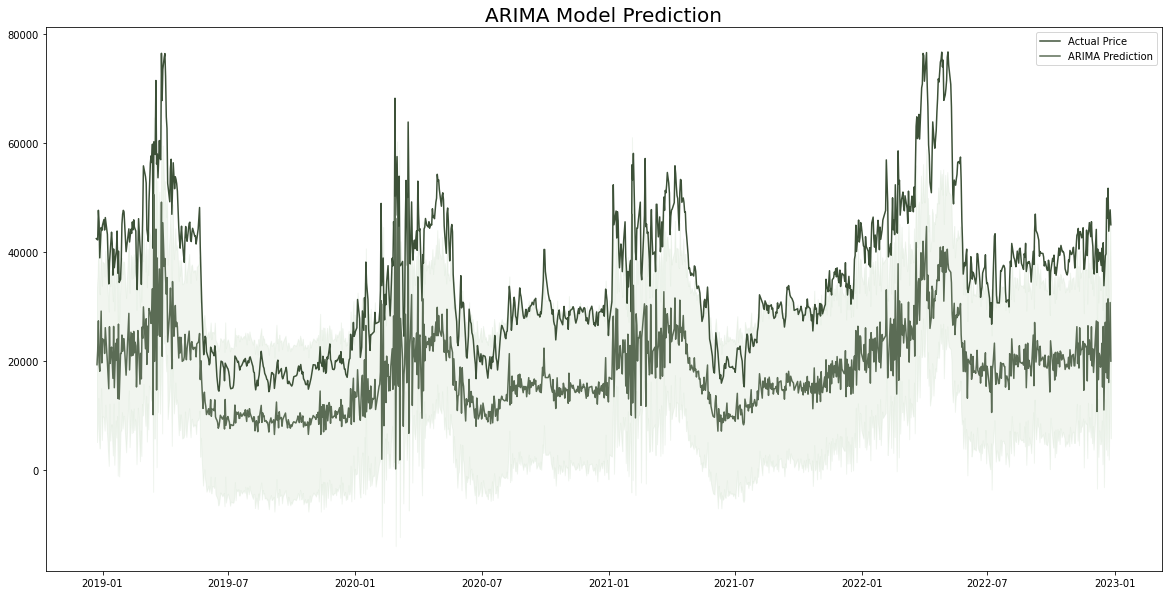

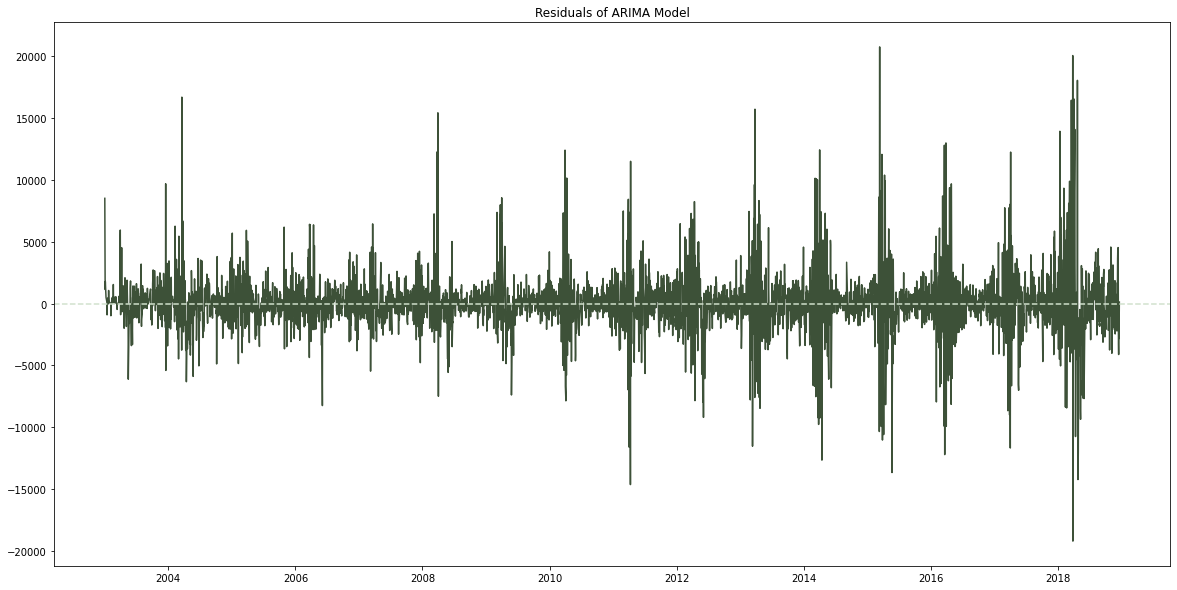

                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                 6118
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -56914.684
Date:                Sat, 23 Nov 2024   AIC                         113835.368
Time:                        18:35:23   BIC                         113855.525
Sample:                             0   HQIC                        113842.361
                               - 6118                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5187      0.021     25.210      0.000       0.478       0.559
ma.L1         -0.7007      0.018    -38.919      0.000      -0.736      -0.665
sigma2      7.133e+06    4.8e+04    148.724      0.0

In [34]:
# Load the data
load_data = pd.read_excel("core_data.xlsx")

# Drop the missing values
data = load_data.drop(["pre_day_price", "pre_year_price", "pre_7day_price"], axis=1)

# using by variables of arima model
target_arima = data["avg_price"]

# index of tartget_arima with date
target_arima.index = data["DATE"]

# build the model with ARIMA
from statsmodels.tsa.arima.model import ARIMA

ARIMA_model = ARIMA(target_arima, order=(1, 1, 1))
ARIMA_model_fit = ARIMA_model.fit()

# coefficient of the model
phi = ARIMA_model_fit.params[0]
theta = ARIMA_model_fit.params[1]
residuals = ARIMA_model_fit.resid

# forecast the future price
ARIMA_preds = []

for i in range(1, len(target_arima)):
    arima_pred = phi * target_arima[i - 1] + theta * residuals[i - 1] + residuals[i]
    ARIMA_preds.append(arima_pred)

# evaluation of the model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale

train_size = int(len(target_arima) * 0.8)
arime_test = target_arima[train_size:]
arima_test = minmax_scale(arime_test)

ARIMA_preds_test = ARIMA_preds[train_size:]
ARIMA_preds_test = minmax_scale(ARIMA_preds_test)

airma_mse = mean_squared_error(arima_test[1:], ARIMA_preds_test)
print("MSE of ARIMA model: ", airma_mse)

# 95% confidence interval
ARIMA_preds = pd.Series(ARIMA_preds, index=target_arima[1:].index)
sigma_test = sqrt(ARIMA_preds.var())
lower = ARIMA_preds - 1.96 * sigma_test
upper = ARIMA_preds + 1.96 * sigma_test

# dataframe of the result
result = pd.DataFrame({"Actual Price": target_arima[train_size:],
                        "ARIMA Prediction": ARIMA_preds[train_size:],
                         "Lower": lower[train_size:], "Upper": upper[train_size:]})


# plot the result 
plt.figure(figsize=(20, 10))
plt.plot(result["Actual Price"], label="Actual Price", color="#3D5138") 
plt.plot(result["ARIMA Prediction"], label="ARIMA Prediction", color="#5B6C55") 
plt.fill_between(result.index, result["Lower"], result["Upper"], color='#D1E1CD', alpha=0.3) 
plt.legend() 
plt.title("ARIMA Model Prediction", fontsize=20) 
plt.show() 



# plot the residual
plt.figure(figsize=(20, 10))
plt.plot(residuals[:train_size],  color="#3D5138")
plt.axhline(y=0, color='#D1E1CD', linestyle='--')
plt.title("Residuals of ARIMA Model")
plt.show() 

# summary of the ARIMA model
print(ARIMA_model_fit.summary())


## Linear Regression

MSE of Linear Regression model:  0.04708429386301129


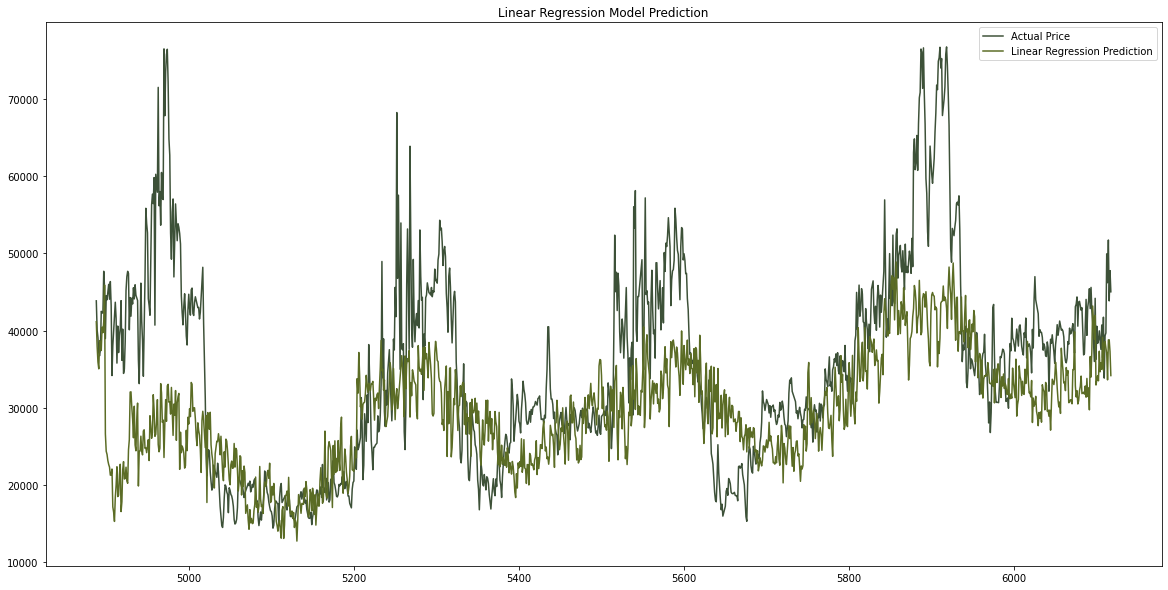

                                 OLS Regression Results                                
Dep. Variable:              avg_price   R-squared (uncentered):                   0.882
Model:                            OLS   Adj. R-squared (uncentered):              0.882
Method:                 Least Squares   F-statistic:                              2282.
Date:                Sat, 23 Nov 2024   Prob (F-statistic):                        0.00
Time:                        18:07:42   Log-Likelihood:                         -51903.
No. Observations:                4885   AIC:                                  1.038e+05
Df Residuals:                    4869   BIC:                                  1.039e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [15]:
# -- Linear Regression Model -- #
from sklearn.linear_model import LinearRegression 

# data for linear regression
data_copy = data.copy().dropna()
data_copy = data_copy.drop("DATE", axis=1)
x_lr = data_copy.drop("avg_price", axis=1)
y_lr = data_copy["avg_price"]

# split the data
train_size = int(len(x_lr) * 0.8)
x_train = x_lr[:train_size] 
y_train = y_lr[:train_size] 
x_test = x_lr[train_size:] 
y_test = y_lr[train_size:]

# build the model
lr_model = LinearRegression() 

# fit the model
lr_model.fit(x_train, y_train) 

# prediction 
lr_preds = lr_model.predict(x_test) 

# evaluation of the model with minmax scale
lr_test = minmax_scale(y_test)
lr_pred_test = minmax_scale(lr_preds)

lr_mse = mean_squared_error(lr_test, lr_pred_test)
print("MSE of Linear Regression model: ", lr_mse)

# dataframe of the result
result_lr = pd.DataFrame({"Actual Price": y_test, 
                            "Linear Regression Prediction": lr_preds}) 

# plot the result
plt.figure(figsize=(20, 10)) 
plt.plot(result_lr["Actual Price"], label="Actual Price", color="#3D5138") 
plt.plot(result_lr["Linear Regression Prediction"], label="Linear Regression Prediction", color="#5B6C25") 
plt.legend() 
plt.title("Linear Regression Model Prediction") 
plt.show() 


# summary of the linear regression model 
olr = sm.OLS(y_train, x_train).fit()
print(olr.summary())



In [26]:
## -- selected variables for the Lr model -- ##

# selected variables by forward selection
raw_data = data.copy().dropna()
y = raw_data["avg_price"]
X = raw_data.drop(columns=["avg_price", "DATE"])

variables = X.columns.tolist()
selected_variables = []
sl_enter = 0.05
sv_per_step = []
adjusted_r_squared = []  
steps = []
step = 0

while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder)
    
    for col in remainder:
        X_temp = X[selected_variables + [col]]
        X_temp = sm.add_constant(X_temp)
        model = sm.OLS(y, X_temp).fit()
        pval[col] = model.pvalues[col]
        
    min_pval = pval.min()
    if min_pval < sl_enter:
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y, sm.add_constant(X[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    
    else:
        break

# drops the variables in selected variables list
X_selected = X[selected_variables]
X_selected = X.drop(["fresh index", "CPI"], axis=1) 

C:\Users\82108\AppData\Local\Temp\ipykernel_12472\2821933301.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)
C:\Users\82108\AppData\Local\Temp\ipykernel_12472\2821933301.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)
C:\Users\82108\AppData\Local\Temp\ipykernel_12472\2821933301.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pval = pd.Series(index=remainder)
C:\Users\82108\AppData\Local\Temp\ipykernel_12472\2821933301.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly t

In [27]:
X_selected.columns

Index(['rainfall', 'snowfall', 'total_sunshine', 'total_solar',
       'average_humidity', '30cm_soil_temperature', 'average_temperature',
       'average_wind', 'oil_y', 'spring_income', 'fall_income',
       'cultivation_area', 'input_labor', 'cost of living'],
      dtype='object')

MSE of Linear Regression model with selected variables:  0.05132062713400977


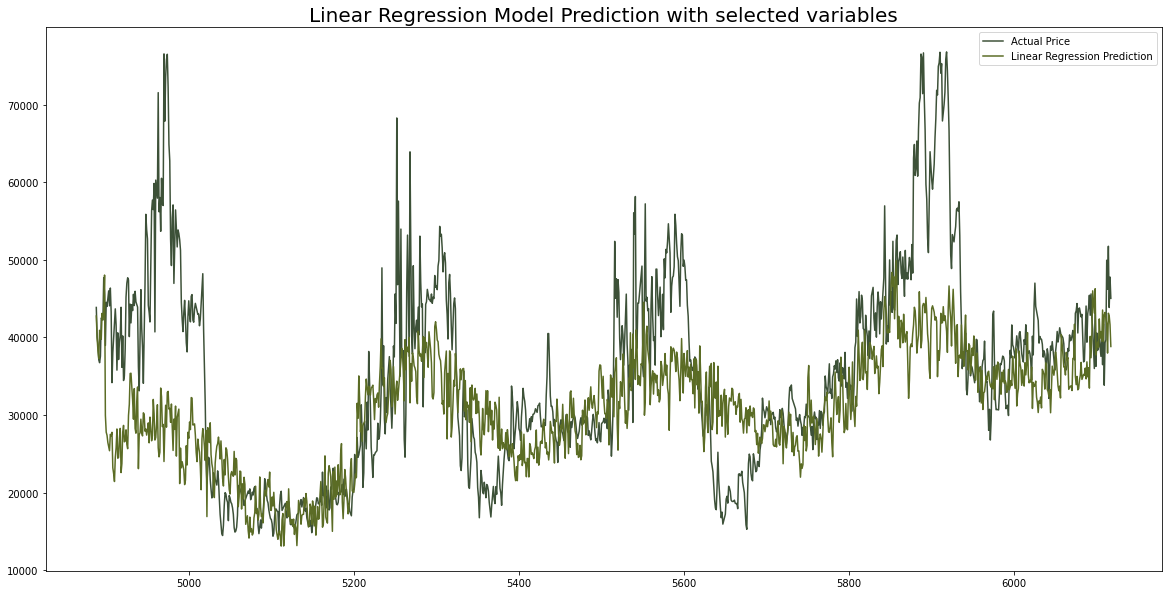

                                 OLS Regression Results                                
Dep. Variable:              avg_price   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                              2538.
Date:                Sat, 23 Nov 2024   Prob (F-statistic):                        0.00
Time:                        18:34:35   Log-Likelihood:                         -51963.
No. Observations:                4885   AIC:                                  1.040e+05
Df Residuals:                    4871   BIC:                                  1.040e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [33]:
# -- Linear Regression Model with selected variables -- #

# data for linear regression
data_copy = data.copy().dropna()
data_copy = data_copy.drop("DATE", axis=1)
x_lr = X_selected
y_lr = data_copy["avg_price"]

# split the data
train_size = int(len(x_lr) * 0.8)
x_train = x_lr[:train_size] 
y_train = y_lr[:train_size] 
x_test = x_lr[train_size:] 

# build the model
lr_model = LinearRegression()

# fit the model
lr_model.fit(x_train, y_train) 

# prediction 
lr_preds = lr_model.predict(x_test) 

# evaluation of the model with minmax scale 
lr_test = minmax_scale(y_test) 
lr_pred_test = minmax_scale(lr_preds) 

lr_mse_sel = mean_squared_error(lr_test, lr_pred_test) 
print("MSE of Linear Regression model with selected variables: ", lr_mse_sel)

# dataframe of the result
result_lr_sel = pd.DataFrame({"Actual Price": y_test, 
                            "Linear Regression Prediction": lr_preds}) 

# plot the result
plt.figure(figsize=(20, 10)) 
plt.plot(result_lr_sel["Actual Price"], label="Actual Price", color ="#3D5138")  
plt.plot(result_lr_sel["Linear Regression Prediction"], label="Linear Regression Prediction", color="#5B6C25") 
plt.legend() 
plt.title("Linear Regression Model Prediction with selected variables", fontsize=20) 
plt.show() 

# summary of the linear regression model 
olr = sm.OLS(y_train, x_train).fit()
print(olr.summary())



In [32]:
# all print statements are in the code
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

print(olr.summary())


                                 OLS Regression Results                                
Dep. Variable:              avg_price   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                              2538.
Date:                Sat, 23 Nov 2024   Prob (F-statistic):                        0.00
Time:                        18:27:01   Log-Likelihood:                         -51963.
No. Observations:                4885   AIC:                                  1.040e+05
Df Residuals:                    4871   BIC:                                  1.040e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

## Lasso & Ridge lr 

MSE of Lasso Regression model:  0.04699827039901068


C:\Users\82108\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.325e+11, tolerance: 7.940e+07
  model = cd_fast.enet_coordinate_descent(


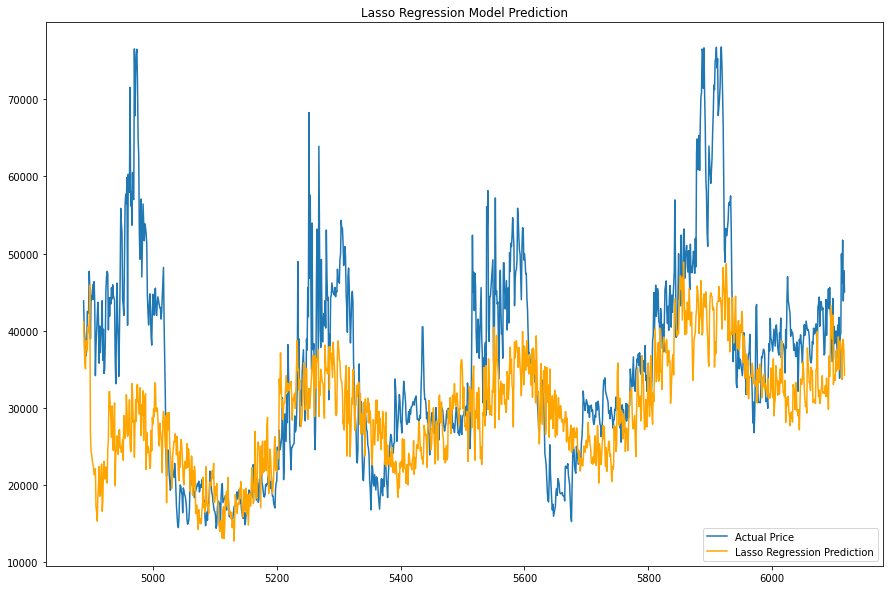

In [36]:
## -- Lasso Regression Model with all variables -- ##
from sklearn.linear_model import Lasso 

# data for lasso regression 
data_copy = data.copy().dropna()
data_copy = data_copy.drop("DATE", axis=1) 
x_lr = data_copy.drop("avg_price", axis=1) 
y_lr = data_copy["avg_price"] 

# split the data
train_size = int(len(x_lr) * 0.8) 
x_train = x_lr[:train_size] 
y_train = y_lr[:train_size] 
x_test = x_lr[train_size:] 
y_test = y_lr[train_size:] 

# build the model 
lasso_model = Lasso(alpha=0.1) 

# fit the model 
lasso_model.fit(x_train, y_train) 

# prediction 
lasso_preds = lasso_model.predict(x_test) 

# evaluation of the model with minmax scale 
lasso_test = minmax_scale(y_test) 
lasso_pred_test = minmax_scale(lasso_preds) 

lasso_mse = mean_squared_error(lasso_test, lasso_pred_test) 
print("MSE of Lasso Regression model: ", lasso_mse) 

# dataframe of the result 
result_lasso = pd.DataFrame({"Actual Price": y_test, 
                            "Lasso Regression Prediction": lasso_preds})

# plot the result 
plt.figure(figsize=(15, 10)) 
plt.plot(result_lasso["Actual Price"], label="Actual Price") 
plt.plot(result_lasso["Lasso Regression Prediction"], label="Lasso Regression Prediction", color="orange") 
plt.legend() 
plt.title("Lasso Regression Model Prediction") 
plt.show() 


MSE of Lasso Regression model with selected variables:  0.05132121506070784


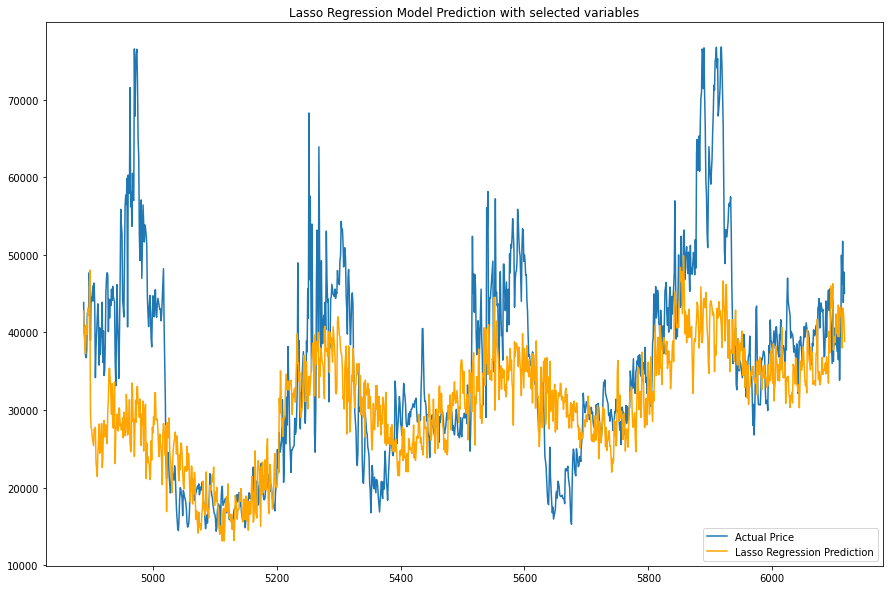

In [38]:
## lasso regression model with selected variables ##
# data for lasso regression 
data_copy = data.copy().dropna() 
data_copy = data_copy.drop("DATE", axis=1) 
x_lr = X_selected 
y_lr = data_copy["avg_price"] 

# split the data 
train_size = int(len(x_lr) * 0.8) 
x_train = x_lr[:train_size] 
y_train = y_lr[:train_size] 
x_test = x_lr[train_size:] 
y_test = y_lr[train_size:] 

# build the model 
lasso_model = Lasso(alpha=0.1)

# fit the model 
lasso_model.fit(x_train, y_train) 

# prediction 
lasso_preds = lasso_model.predict(x_test) 

# evaluation of the model with minmax scale 
lasso_test = minmax_scale(y_test) 
lasso_pred_test = minmax_scale(lasso_preds) 

lasso_mse_sel = mean_squared_error(lasso_test, lasso_pred_test) 
print("MSE of Lasso Regression model with selected variables: ", lasso_mse_sel) 

# dataframe of the result 
result_lasso_sel = pd.DataFrame({"Actual Price": y_test, 
                                "Lasso Regression Prediction": lasso_preds})

# plot the result 
plt.figure(figsize=(15, 10)) 
plt.plot(result_lasso_sel["Actual Price"], label="Actual Price") 
plt.plot(result_lasso_sel["Lasso Regression Prediction"], label="Lasso Regression Prediction", color="orange") 
plt.legend() 
plt.title("Lasso Regression Model Prediction with selected variables") 
plt.show() 



In [39]:
## -- optimization of the lasso regression model -- ##
from sklearn.model_selection import GridSearchCV 

# data for lasso regression 
data_copy = data.copy().dropna() 
data_copy = data_copy.drop("DATE", axis=1) 
x_lr = data_copy.drop("avg_price", axis=1) 
y_lr = data_copy["avg_price"] 

# split the data 
train_size = int(len(x_lr) * 0.8) 
x_train = x_lr[:train_size] 
y_train = y_lr[:train_size] 
x_test = x_lr[train_size:] 
y_test = y_lr[train_size:] 

# Lasso regression model optimization
alpha_range = [0.001, 0.01, 0.1, 1, 10, 100]
lasso = Lasso()
param_grid_lasso = {'alpha': alpha_range}
grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, scoring='neg_mean_squared_error', cv=5)
grid_search_lasso.fit(x_train, y_train)

# best alpha
best_alpha_lasso = grid_search_lasso.best_params_['alpha']
print("Best Lasso alpha:", best_alpha_lasso)



C:\Users\82108\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.737e+11, tolerance: 6.437e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\82108\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e+11, tolerance: 6.854e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\82108\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\loca

Best Lasso alpha: 100


C:\Users\82108\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.289e+11, tolerance: 7.940e+07
  model = cd_fast.enet_coordinate_descent(


MSE of optimized Lasso Regression model:  0.046908293204421095


C:\Users\82108\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.289e+11, tolerance: 7.940e+07
  model = cd_fast.enet_coordinate_descent(


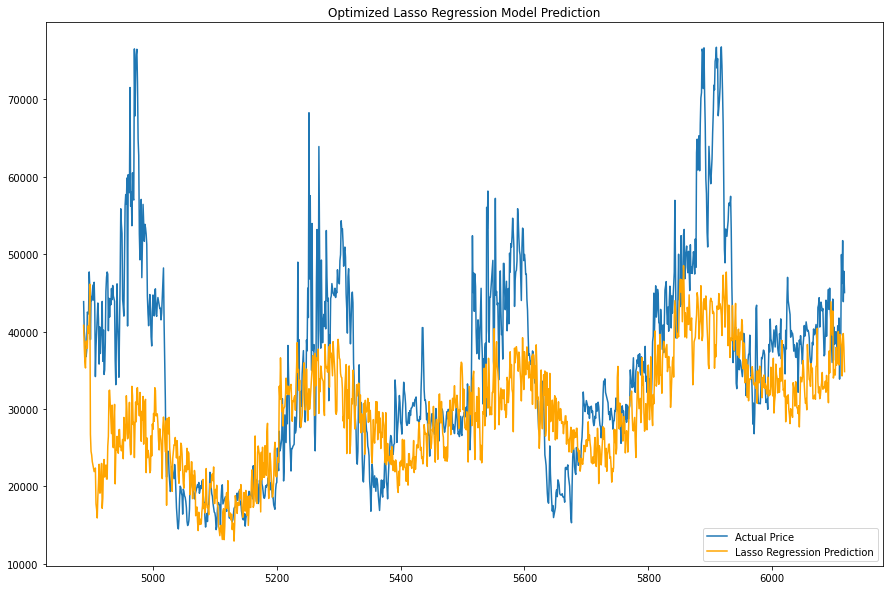

In [40]:
## -- optimization of the lasso regression model with all variables -- ##
# build the model
lasso_model = Lasso(alpha=best_alpha_lasso) 

# fit the model 
lasso_model.fit(x_train, y_train) 

# prediction 
lasso_preds = lasso_model.predict(x_test) 

# evaluation of the model with minmax scale 
lasso_test = minmax_scale(y_test) 
lasso_pred_test = minmax_scale(lasso_preds) 

lasso_mse_opt = mean_squared_error(lasso_test, lasso_pred_test) 
print("MSE of optimized Lasso Regression model: ", lasso_mse_opt) 

# dataframe of the result 
result_lasso_opt = pd.DataFrame({"Actual Price": y_test, 
                                "Lasso Regression Prediction": lasso_preds})       

# plot the result 
plt.figure(figsize=(15, 10)) 
plt.plot(result_lasso_opt["Actual Price"], label="Actual Price") 
plt.plot(result_lasso_opt["Lasso Regression Prediction"], label="Lasso Regression Prediction", color="orange") 
plt.legend() 
plt.title("Optimized Lasso Regression Model Prediction") 
plt.show() 


MSE of Lasso Regression model with selected variables:  0.051973519654562324


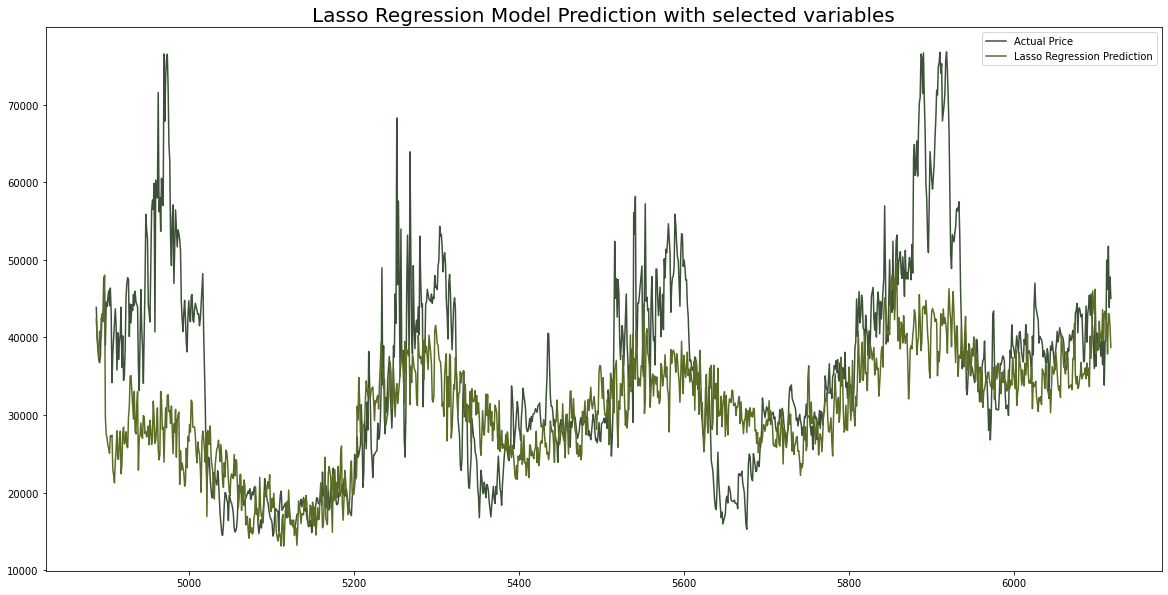

[ 5.68432382e+01 -5.93186034e+02 -1.30533080e+03  8.80411624e+02
 -1.72602281e+02  3.14795968e+01 -4.92337507e+02 -1.18707128e+02
 -3.51510010e+01  5.06921102e-04  1.89634699e-02  5.86159544e-02
  2.27638863e+02  8.69909301e+02]
-100514.25754652829
{'alpha': 100, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In [ ]:
## -- optimization of the lasso regression model with selected variables -- ##
# data for lasso regression 
data_copy = data.copy().dropna() 
data_copy = data_copy.drop("DATE", axis=1) 
x_lr = X_selected 
y_lr = data_copy["avg_price"] 

# split the data 
train_size = int(len(x_lr) * 0.8) 
x_train = x_lr[:train_size] 
y_train = y_lr[:train_size] 
x_test = x_lr[train_size:] 
y_test = y_lr[train_size:] 

# build the model 
lasso_model = Lasso(alpha=best_alpha_lasso)

# fit the model 
lasso_model.fit(x_train, y_train) 

# prediction 
lasso_preds = lasso_model.predict(x_test) 

# evaluation of the model with minmax scale 
lasso_test = minmax_scale(y_test) 
lasso_pred_test = minmax_scale(lasso_preds) 

lasso_mse_sel = mean_squared_error(lasso_test, lasso_pred_test) 
print("MSE of Lasso Regression model with selected variables: ", lasso_mse_sel) 

# dataframe of the result 
result_lasso_sel = pd.DataFrame({"Actual Price": y_test, 
                                "Lasso Regression Prediction": lasso_preds})

# plot the result 
plt.figure(figsize=(20, 10)) 
plt.plot(result_lasso_sel["Actual Price"], label="Actual Price", color="#3D5138")  
plt.plot(result_lasso_sel["Lasso Regression Prediction"], label="Lasso Regression Prediction", color="#5B6C25") 
plt.legend() 
plt.title("Lasso Regression Model Prediction with selected variables", fontsize=20) 
plt.show() 



MSE of Ridge Regression model:  0.047082177370694214


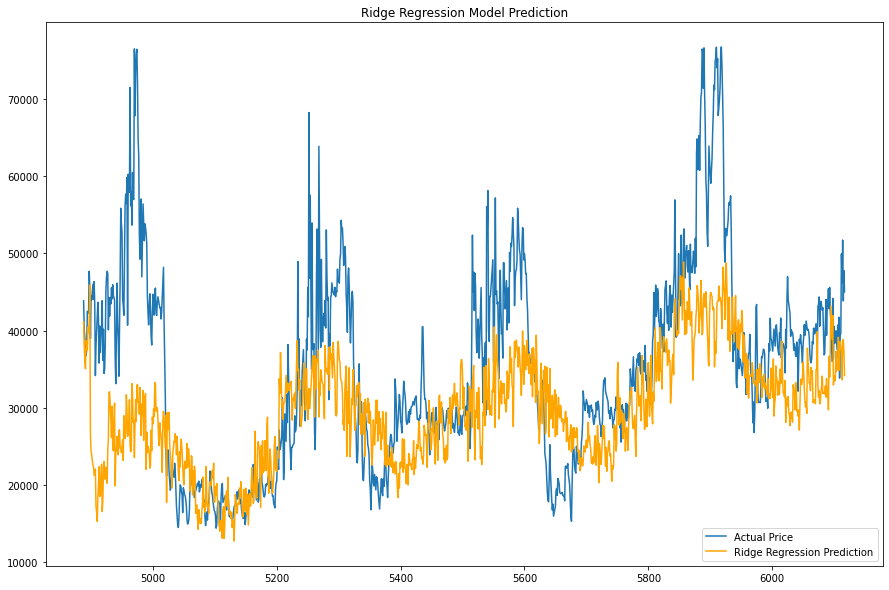

In [44]:
## -- Ridge regressio model with all variables -- ##
from sklearn.linear_model import Ridge

# data for ridge regression 
data_copy = data.copy().dropna() 
data_copy = data_copy.drop("DATE", axis=1) 
x_lr = data_copy.drop("avg_price", axis=1) 
y_lr = data_copy["avg_price"] 

# split the data 
train_size = int(len(x_lr) * 0.8) 
x_train = x_lr[:train_size] 
y_train = y_lr[:train_size] 
x_test = x_lr[train_size:] 

# build the model 
ridge_model = Ridge()

# fit the model 
ridge_model.fit(x_train, y_train) 

# prediction 
ridge_preds = ridge_model.predict(x_test) 

# evaluation of the model with minmax scale 
ridge_test = minmax_scale(y_test) 
ridge_pred_test = minmax_scale(ridge_preds) 

ridge_mse = mean_squared_error(ridge_test, ridge_pred_test) 
print("MSE of Ridge Regression model: ", ridge_mse) 

# dataframe of the result 
result_ridge = pd.DataFrame({"Actual Price": y_test, 
                            "Ridge Regression Prediction": ridge_preds})    

# plot the result 
plt.figure(figsize=(15, 10)) 
plt.plot(result_ridge["Actual Price"], label="Actual Price") 
plt.plot(result_ridge["Ridge Regression Prediction"], label="Ridge Regression Prediction", color="orange") 
plt.legend() 
plt.title("Ridge Regression Model Prediction") 
plt.show() 



MSE of Ridge Regression model with selected variables:  0.05132158837896858


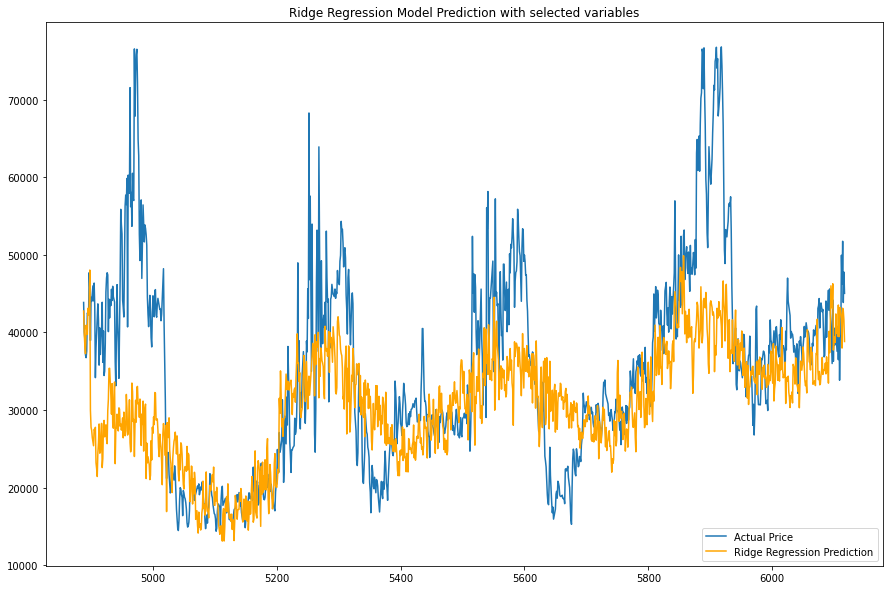

In [45]:
## -- Ridge regression model with selected variables -- ##
# data for ridge regression 
data_copy = data.copy().dropna()
data_copy = data_copy.drop("DATE", axis=1)
x_lr = X_selected
y_lr = data_copy["avg_price"]

# split the data
train_size = int(len(x_lr) * 0.8)
x_train = x_lr[:train_size]
y_train = y_lr[:train_size]
x_test = x_lr[train_size:]

# build the model
ridge_model = Ridge()

# fit the model
ridge_model.fit(x_train, y_train)

# prediction
ridge_preds = ridge_model.predict(x_test)

# evaluation of the model with minmax scale
ridge_test = minmax_scale(y_test)
ridge_pred_test = minmax_scale(ridge_preds)

ridge_mse_sel = mean_squared_error(ridge_test, ridge_pred_test)
print("MSE of Ridge Regression model with selected variables: ", ridge_mse_sel)

# dataframe of the result
result_ridge_sel = pd.DataFrame({"Actual Price": y_test,
                                "Ridge Regression Prediction": ridge_preds})    

# plot the result
plt.figure(figsize=(15, 10))
plt.plot(result_ridge_sel["Actual Price"], label="Actual Price")
plt.plot(result_ridge_sel["Ridge Regression Prediction"], label="Ridge Regression Prediction", color="orange")
plt.legend()
plt.title("Ridge Regression Model Prediction with selected variables")
plt.show()


In [46]:
## -- optimization of the ridge regression model with all variables -- ##


## -- optimization of the lasso regression model -- ##
from sklearn.model_selection import GridSearchCV 

# data for lasso regression 
data_copy = data.copy().dropna() 
data_copy = data_copy.drop("DATE", axis=1) 
x_lr = data_copy.drop("avg_price", axis=1) 
y_lr = data_copy["avg_price"] 

# split the data 
train_size = int(len(x_lr) * 0.8) 
x_train = x_lr[:train_size] 
y_train = y_lr[:train_size] 
x_test = x_lr[train_size:] 
y_test = y_lr[train_size:] 

alpha_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

ridge = Ridge()
param_grid_ridge = {'alpha': alpha_range}
grid_search_ridge = GridSearchCV(ridge, param_grid_ridge, scoring='neg_mean_squared_error', cv=5)
grid_search_ridge.fit(x_train, y_train)

# Ridge 최적 alpha 값
best_alpha_ridge = grid_search_ridge.best_params_['alpha']
print("Best Ridge alpha:", best_alpha_ridge)

Best Ridge alpha: 1000


MSE of Ridge Regression model:  0.04677122262510834


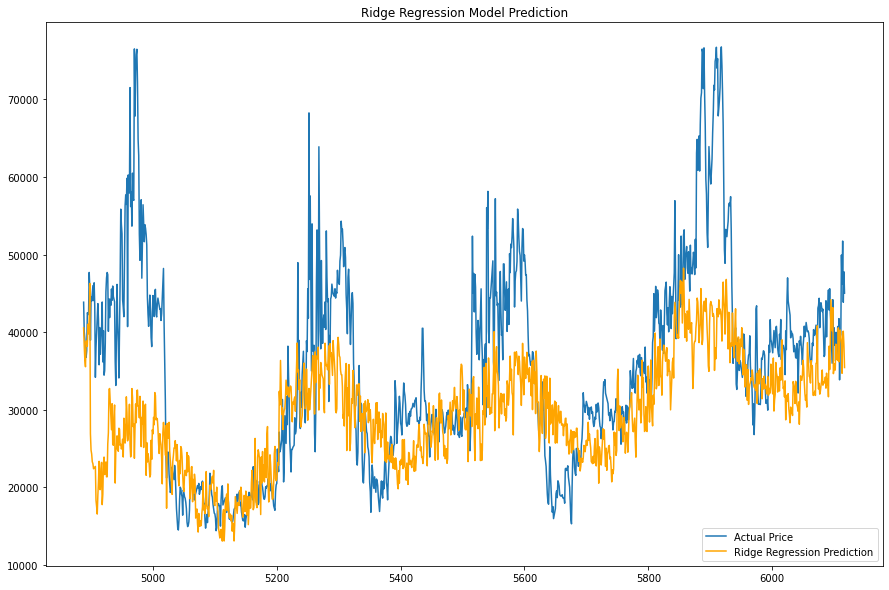

In [47]:
## -- Ridge regressio model with all variables -- ##
from sklearn.linear_model import Ridge

# data for ridge regression 
data_copy = data.copy().dropna() 
data_copy = data_copy.drop("DATE", axis=1) 
x_lr = data_copy.drop("avg_price", axis=1) 
y_lr = data_copy["avg_price"] 

# split the data 
train_size = int(len(x_lr) * 0.8) 
x_train = x_lr[:train_size] 
y_train = y_lr[:train_size] 
x_test = x_lr[train_size:] 

# build the model 
ridge_model = Ridge(alpha=best_alpha_ridge)

# fit the model 
ridge_model.fit(x_train, y_train) 

# prediction 
ridge_preds = ridge_model.predict(x_test) 

# evaluation of the model with minmax scale 
ridge_test = minmax_scale(y_test) 
ridge_pred_test = minmax_scale(ridge_preds) 

ridge_mse = mean_squared_error(ridge_test, ridge_pred_test) 
print("MSE of Ridge Regression model: ", ridge_mse) 

# dataframe of the result 
result_ridge = pd.DataFrame({"Actual Price": y_test, 
                            "Ridge Regression Prediction": ridge_preds})    

# plot the result 
plt.figure(figsize=(15, 10)) 
plt.plot(result_ridge["Actual Price"], label="Actual Price") 
plt.plot(result_ridge["Ridge Regression Prediction"], label="Ridge Regression Prediction", color="orange") 
plt.legend() 
plt.title("Ridge Regression Model Prediction") 
plt.show() 



MSE of Ridge Regression model with selected variables:  0.052282771484038634


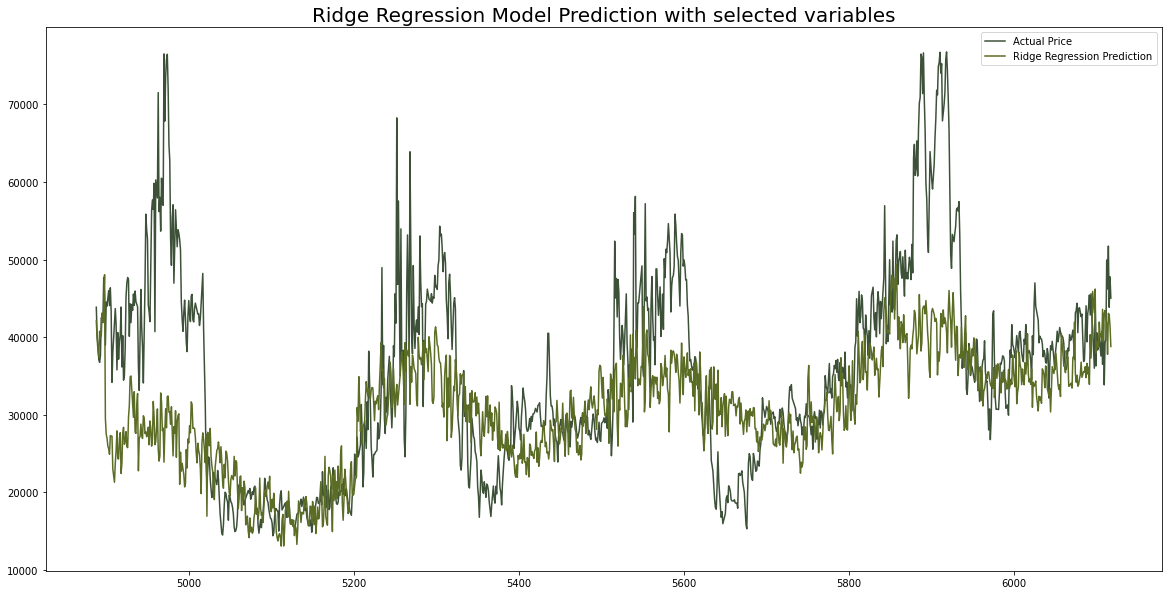

In [49]:
## -- Ridge regression model with selected variables -- ##
# data for ridge regression 
data_copy = data.copy().dropna()
data_copy = data_copy.drop("DATE", axis=1)
x_lr = X_selected
y_lr = data_copy["avg_price"]

# split the data
train_size = int(len(x_lr) * 0.8)
x_train = x_lr[:train_size]
y_train = y_lr[:train_size]
x_test = x_lr[train_size:]

# build the model
ridge_model = Ridge(alpha=best_alpha_ridge)

# fit the model
ridge_model.fit(x_train, y_train)

# prediction
ridge_preds = ridge_model.predict(x_test)

# evaluation of the model with minmax scale
ridge_test = minmax_scale(y_test)
ridge_pred_test = minmax_scale(ridge_preds)

ridge_mse_sel = mean_squared_error(ridge_test, ridge_pred_test)
print("MSE of Ridge Regression model with selected variables: ", ridge_mse_sel)

# dataframe of the result
result_ridge_sel = pd.DataFrame({"Actual Price": y_test,
                                "Ridge Regression Prediction": ridge_preds})    

# plot the result
plt.figure(figsize=(20, 10))
plt.plot(result_ridge_sel["Actual Price"], label="Actual Price", color="#3D5138")
plt.plot(result_ridge_sel["Ridge Regression Prediction"], label="Ridge Regression Prediction", color="#5B6C25")
plt.legend()
plt.title("Ridge Regression Model Prediction with selected variables", fontsize=20)
plt.show()


## ensamble model with lasso, rigde and lr

MSE of Ensemble Model:  0.04683439104815578


C:\Users\82108\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.289e+11, tolerance: 7.940e+07
  model = cd_fast.enet_coordinate_descent(


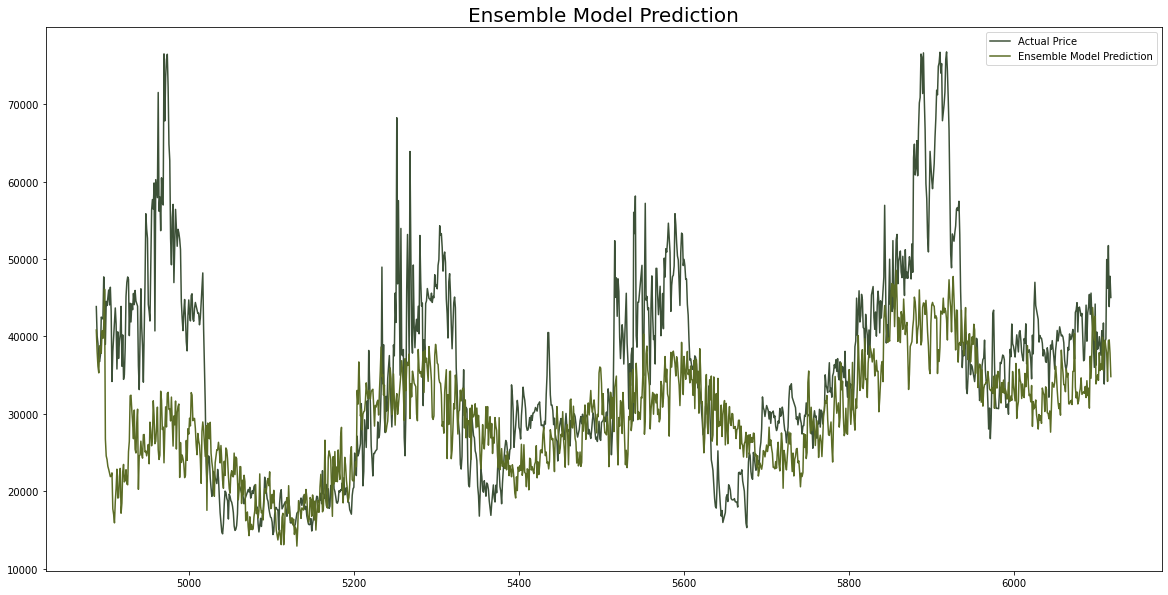

In [ ]:
## -- Ensemble model with lasso, rigde and linear -- ##
from sklearn.ensemble import VotingRegressor

# data for ensemble model 
data_copy = data.copy().dropna() 
data_copy = data_copy.drop("DATE", axis=1) 
x_en = data_copy.drop("avg_price", axis=1) 
y_en = data_copy["avg_price"] 

# split the data 
train_size = int(len(x_en) * 0.8) 
x_train = x_en[:train_size] 
y_train = y_en[:train_size]
x_test = x_en[train_size:] 
y_test = y_en[train_size:] 

# build the model
lasso = Lasso(alpha=best_alpha_lasso) 
ridge = Ridge(alpha=best_alpha_ridge) 
linear = LinearRegression() 

ensemble_model = VotingRegressor(estimators=[('lasso', lasso), ('ridge', ridge), ('linear', linear)]) 

# fit the model 
ensemble_model.fit(x_train, y_train) 

# prediction 
ensemble_preds = ensemble_model.predict(x_test) 

# evaluation of the model with minmax scale 
ensemble_test = minmax_scale(y_test) 

ensemble_pred_test = minmax_scale(ensemble_preds) 

ensemble_mse = mean_squared_error(ensemble_test, ensemble_pred_test) 
print("MSE of Ensemble Model: ", ensemble_mse) 

# dataframe of the result 
result_ensemble = pd.DataFrame({"Actual Price": y_test, 
                                "Ensemble Model Prediction": ensemble_preds}) 

# plot the result 
plt.figure(figsize=(20, 10)) 
plt.plot(result_ensemble["Actual Price"], label="Actual Price", color="#3D5138")  
plt.plot(result_ensemble["Ensemble Model Prediction"], label="Ensemble Model Prediction", color="#5B6C25") 
plt.legend() 
plt.title("Ensemble Model Prediction", fontsize=20) 
plt.show() 



## LSTM 

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 257964544.0000
Epoch 2/100
 99/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149002304.0000

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144538736.0000
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 140331696.0000
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135786448.0000
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134040424.0000
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133647808.0000
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133868648.0000
Epoch 8/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122148816.0000
Epoch 9/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142255376.0000
Epoch 10/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 145786400.0000
Epoch 11/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130206064.0000
Epoch 12/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132392416.0000
Epoch 13/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 126577984.0000
Epoch 14/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132428272.0000
Epoch 15/100
153/15

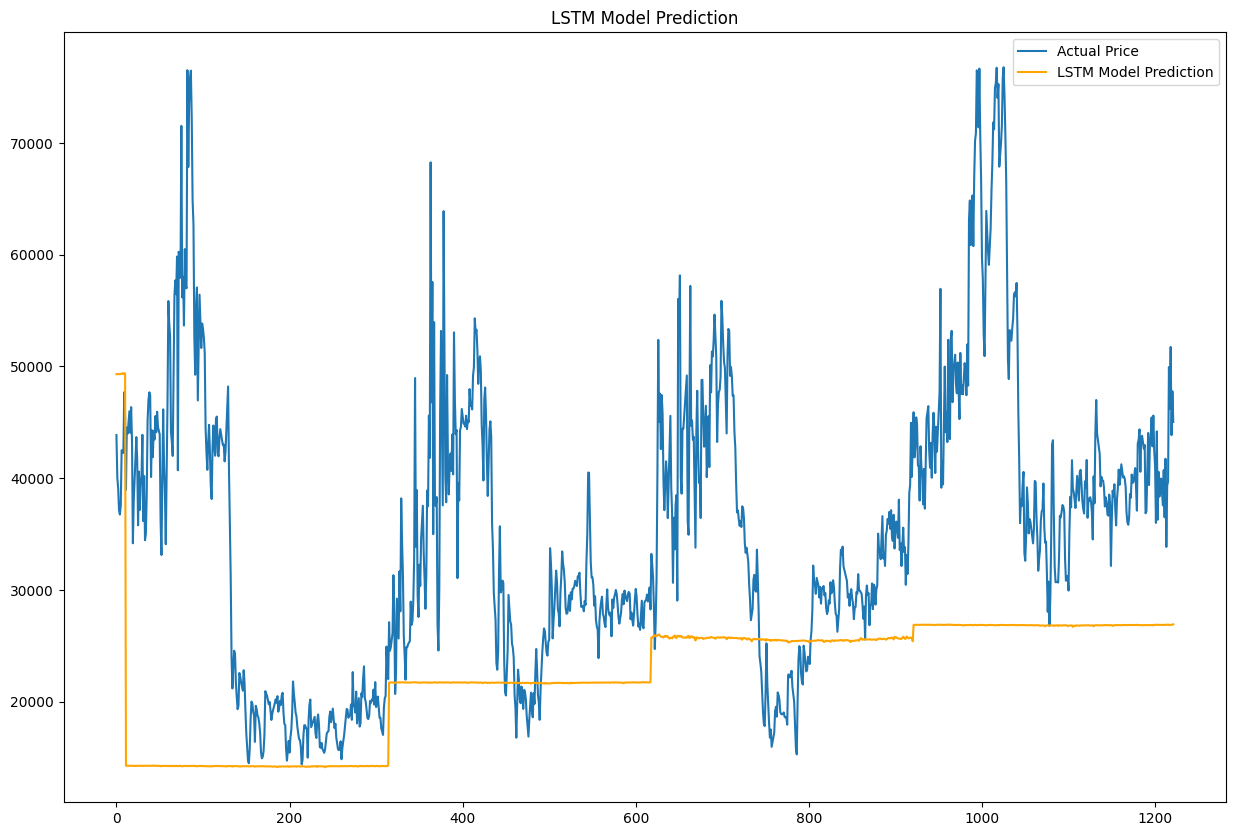

In [124]:
## -- LSTM model -- ##
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout 
from sklearn.preprocessing import MinMaxScaler 
from keras.callbacks import EarlyStopping 

# data for LSTM model
data_copy = data.copy().dropna() 
data_copy = data_copy.drop("DATE", axis=1) 
x_lstm = data_copy.drop("avg_price", axis=1).values
y_lstm = data_copy["avg_price"].values

# split the data 
train_size = int(len(x_lstm) * 0.8) 
x_train = x_lstm[:train_size] 
y_train = y_lstm[:train_size] 
x_test = x_lstm[train_size:]
y_test = y_lstm[train_size:] 

# reshape the data 
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1]) 
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1]) 

# build the model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, x_train.shape[2])))
lstm_model.add(Dense(25, activation='relu'))
lstm_model.add(Dense(10, activation='relu'))
lstm_model.add(Dense(1))

# compile the model 
lstm_model.compile(optimizer='adam', loss='mse') 

# early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 

# fit the model 
lstm_model.fit(x_train, y_train, epochs=100, callbacks=[early_stop]) 

# prediction 
lstm_preds = lstm_model.predict(x_test) 

# evaluation of the model with minmax scale
lstm_test = minmax_scale(y_test) 
lstm_pred_test = minmax_scale(lstm_preds) 

lstm_mse = mean_squared_error(lstm_test, lstm_pred_test) 
print("MSE of LSTM Model: ", lstm_mse) 


# dataframe of the result 
result_lstm = pd.DataFrame({"Actual Price": y_test, 
                            "LSTM Model Prediction": lstm_preds.flatten()}) 

# plot the result 
plt.figure(figsize=(15, 10)) 
plt.plot(result_lstm["Actual Price"], label="Actual Price") 
plt.plot(result_lstm["LSTM Model Prediction"], label="LSTM Model Prediction", color="orange") 
plt.legend()
plt.title("LSTM Model Prediction") 
plt.show() 




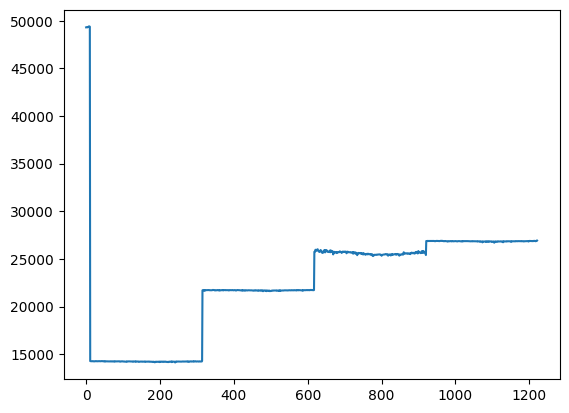

In [130]:
plt.plot(lstm_preds)

@ > 

1. 지수와 주가 수익률의 관계 제시
2. 헤징 전략을 평가 제시


> 목적 : 변동성 전이지수

GARCH model
이분산성 예측 모델도 사용 가능함

